# Figure 4

imports

In [1]:
import torch, os, sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.funcs import *
from boltzmann_machines.RTRBM import RTRBM
from utils.poisson_generated_data import PoissonTimeShiftedData

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

In this notebook we inspect the ability of the RTRBM to extract temporal dynamics of neural assemblies as a function of the interaction time. We hypothesise it is crucial to sample the data at the right frequency, such that most interactions happen at the same delay as the sampling. We test this by creating surrogate data that has temporal interactions with a delay of 4 time-steps. By down-sampling this data, training RTRBMs and quantifying their reconstruction performance we test this hypothesis.

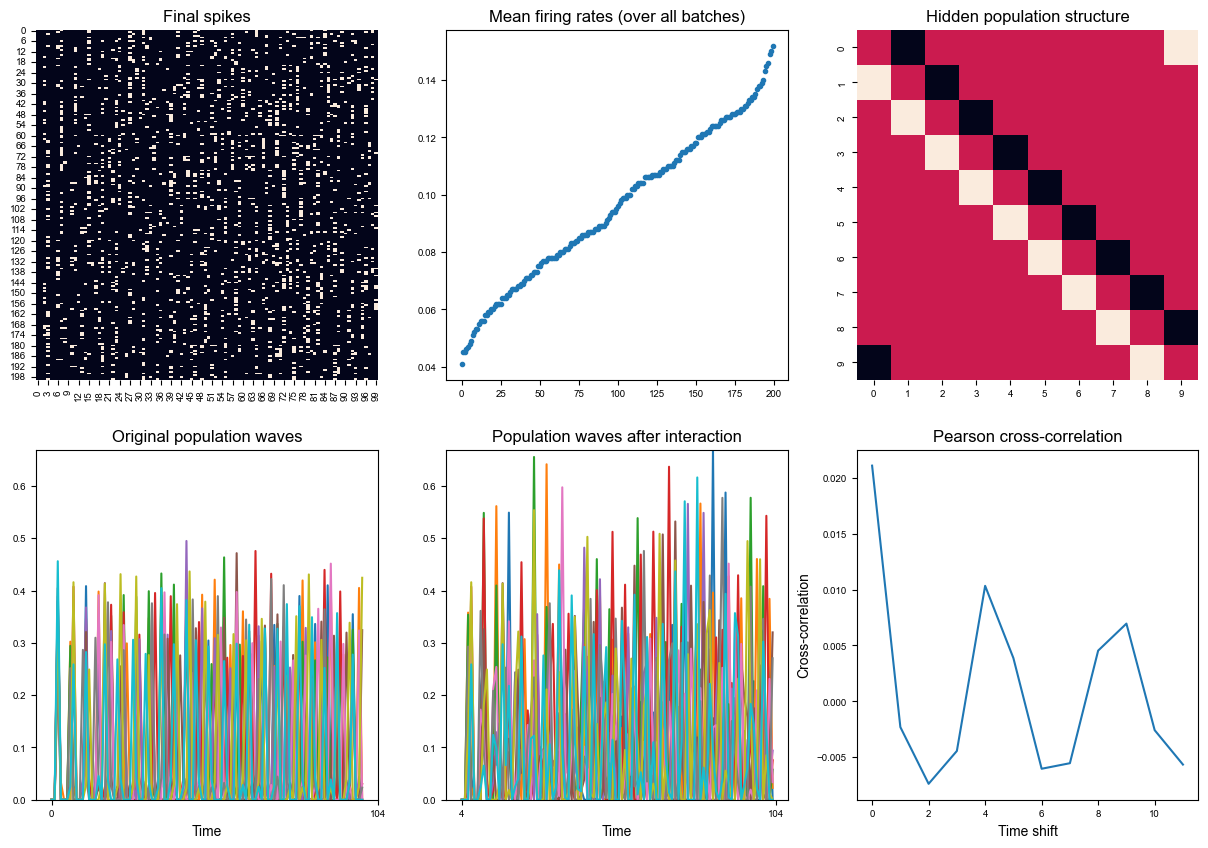

In [2]:
# population interaction delay
interaction_delay = 4

# number of populations and hidden units
n_h = 10 #3

# number of neurons per population
neurons_per_population = 20

# create temporal connections
U_hat = create_U_hat(n_h) / 0.17 #/ 0.36

# create data
gaus = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h,
    n_batches=1,
    norm=1,
    time_steps_per_batch=1000,
    fr_mode='gaussian',
    delay=interaction_delay, frequency_range=[20, 25],
    temporal_connections=U_hat,
)

# plot some statistics to get a sense of the data
axes = gaus.plot_stats(T=100)
plt.show()

In [3]:
path2dir = r'C:\Users\sebas\OneDrive\Intern\RTRBM'

if not os.path.isfile(path2dir + '/models/figure4_downsampling/run10/downsampled10/rtrbm'):
    rtrbm_list = []
    # perform 10 runs
    for n in range(10):

        # create data
        gaus = PoissonTimeShiftedData(
                neurons_per_population=neurons_per_population,
                n_populations=n_h,
                n_batches=50,
                norm=1,
                time_steps_per_batch=10000,
                fr_mode='gaussian',
                delay=interaction_delay, frequency_range=[20, 25],
                temporal_connections=U_hat,
            )

        # down-sample data by 1, 2, ..., 10
        for d in tqdm(np.arange(10) + 1):

            # perform down sampling, only take 35000 time-steps
            data = resample(reshape(gaus.data.detach().clone()), sr=d, mode=2)[:, :50000]

            # reshape data to batches
            data = reshape(data, T=20, n_batches=2500)

            # take 280 train batches and 70 test batches
            train, test = data[..., :2000], data[..., 2000:]

            # initialize and train RTRBM
            rtrbm = RTRBM(train, n_hidden=n_h, device='cuda')
            rtrbm.learn(n_epochs=250, batch_size=10, CDk=10, mom=0.9, wc=0.0001, max_lr=5e-3, min_lr=5e-4,
                        lr_schedule='geometric_decay', start_decay=50,disable_tqdm=True)

            # save test set to class
            rtrbm.test = test

            # save list
            torch.save(rtrbm[d-1], path2dir + '/models/figure4_downsampling/run'+str(n+1)+'/downsampled'+str(d+1)+'/rtrbm')

else:
    rtrbm_list = []
    for n in range(1, 11):
        for d in range(1, 11):
            rtrbm_list += [torch.load(path2dir + '/models/figure4_downsampling/run'+str(n)+'/downsampled'+str(d)+'/rtrbm')]


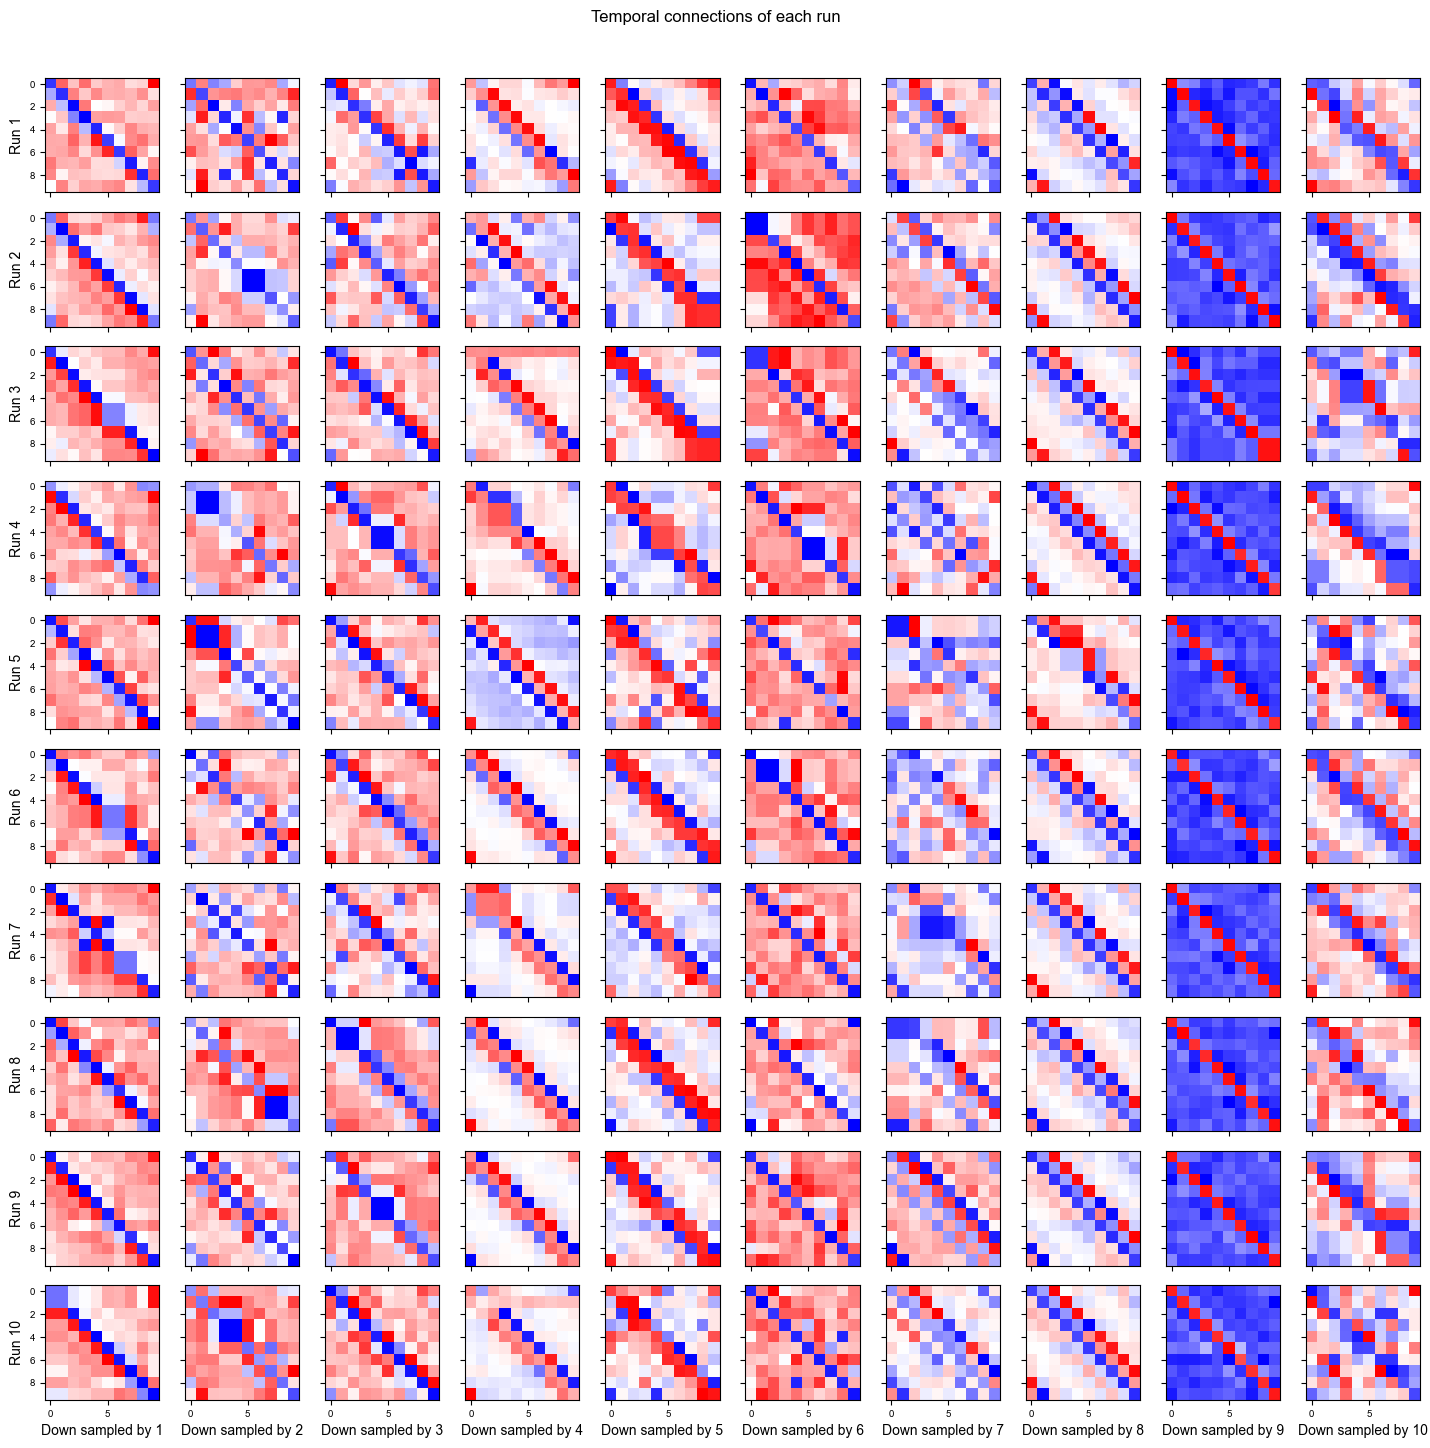

In [4]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True)

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

for i, (rtrbm, ax) in enumerate(zip(rtrbm_list, axs.flatten())):

    W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, U_true=None)
    ax.imshow(U_trained, cmap=plt.get_cmap('bwr'))

    row = i // 10
    col = i % 10
    if col == 0:
        ax.set_ylabel('Run %d' % (row + 1))
    if row == 9:
        ax.set_xlabel('Down sampled by %d' % (col + 1))

fig.suptitle('Temporal connections of each run')
plt.tight_layout(pad=3, h_pad=1.08, w_pad=1.08)

plt.show()

### figure panel 1
Raster plot data

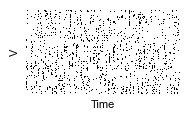

In [5]:
fig, ax = plt.subplots(figsize=(2, 1.3))

colors = ['white', 'black']
cmap = LinearSegmentedColormap.from_list('', colors, 2)
sns.heatmap(gaus.data[:, :500, 0], cbar=False, cmap=cmap, vmin=0, vmax=1, xticklabels=100)

ax.set_xlabel('Time', fontsize=8)
ax.set_ylabel('V', fontsize=8)
ax.set_yticks([])
ax.set_xticks([])
plt.tight_layout()
plt.show()


### figure panel 2
Cross correlation of data


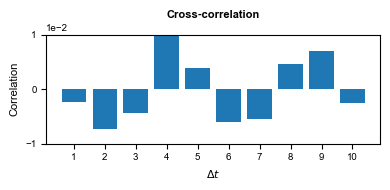

In [6]:
cross_corr = torch.zeros(11)
for dt in range(11):
    cross_corr[dt] = torch.mean(cross_correlation(reshape(gaus.data.detach().clone())[:,:10000], time_shift=dt, mode='Pearson'))

fig, ax = plt.subplots(figsize=(4, 2))

ax.bar(np.arange(10) + 1, cross_corr[1:])
ax.set_title('Cross-correlation', fontsize=8, fontweight='bold', pad=12)
ax.set_xlabel('$\Delta t$', fontsize=8)
ax.set_ylabel('Correlation', fontsize=8)
ax.set_ylim([-0.01, 0.01])
ax.set_yticks([-0.01, 0, 0.01])
# ax.set_yticklabels([-0.003, 0, 0.003], fontsize=7)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=7)

plt.tight_layout()

plt.show()

### figure panel 4
Comparison between $U$ and $\hat{U}$


In [32]:
from scipy.special import rel_entr
KL = torch.empty(len(rtrbm_list))

for i, rtrbm in enumerate(rtrbm_list):

    W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, U_true=None)
    KL[i] = sum(rel_entr(U_trained.ravel()/torch.sum(U_trained), U_hat.ravel()+0.01))

In [ ]:
correlation_U = torch.empty(len(rtrbm_list))

for i, rtrbm in enumerate(rtrbm_list):

    W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, U_true=None)
    correlation_U[i] = torch.corrcoef(torch.stack([U_trained.ravel(), U_hat.ravel()]))[1, 0]

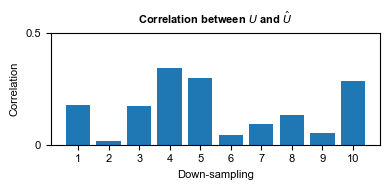

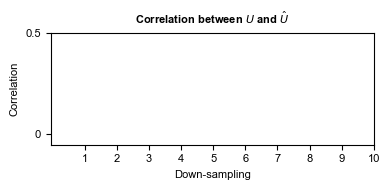

In [10]:
fig, ax = plt.subplots(figsize=(4, 2))

ax.bar(np.arange(10) + 1, torch.mean(np.reshape(abs(correlation_U), (10, 10)), 0))
ax.set_title('Correlation between $U$ and $\hat{U}$', fontsize=8, fontweight='bold')
ax.set_xlabel('Down-sampling', fontsize=8)
ax.set_ylabel('Correlation', fontsize=8)
ax.set_yticks([0, 0.5])
ax.set_yticklabels([0, 0.5], fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=8)
plt.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(4, 2))

ax.bar(np.arange(10) + 1, torch.mean(np.reshape(abs(KL), (10, 10)), 0))
ax.set_title('Correlation between $U$ and $\hat{U}$', fontsize=8, fontweight='bold')
ax.set_xlabel('Down-sampling', fontsize=8)
ax.set_ylabel('Correlation', fontsize=8)
ax.set_yticks([0, 0.5])
ax.set_yticklabels([0, 0.5], fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=8)
plt.tight_layout()

plt.show()


